# AIExpo Learning Session #04
### COMPUTER VISION  
by [Sushil Thapa](www.thapasushil.com.np) / [Github](https://github.com/Sushil-Thapa/AIExpo-learning-session.git)

## Introduction

In this tutorial we will implement a simple Convolutional Neural Network in Pytorch which has a classification accuracy of about 99%, or more if you make some of the suggested exercises.  

### Comvolutional Neural Network (CNN)

Convolutional Networks work by moving small filters across the input image. This means the filters are re-used for recognizing patterns throughout the entire input image. This makes the Convolutional Networks much more powerful than Fully-Connected networks with the same number of variables. This in turn makes the Convolutional Networks faster to train.

#### Flowchart
<img src="assets/01_network_flowchart.png"></img>

## Imports

In [1]:
import torch

# Setting seeds and device
torch.manual_seed(42)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Device {}".format(device))

# Input Image Dimensions
IMG_WIDTH = 425
IMG_HEIGHT = 618

batch_size = 32


Device cuda:0


## Building Dataset

<img src="assets/sample.jpeg"></img>

In [2]:
import os
BASE_DIR=os.path.abspath("./")
DATA_DIR=os.path.join(BASE_DIR, "data")

# Specify Dataset paths for later use
# Alternative: stratified train-test split
DATA = {
    'train': {
        'data_dir' : os.path.join(DATA_DIR, "Train/trainset"),
        'labels' : os.path.join(DATA_DIR,"Train/trainset_exp.csv")
    },
    'val': {
        'data_dir' : os.path.join(DATA_DIR, "Val/valset"),
        'labels' : os.path.join(DATA_DIR,"Val/valset.csv")
    },
    'test': {
        'data_dir' : os.path.join(DATA_DIR, "Test/testset"),
        'labels' : os.path.join(DATA_DIR,"Test/testset.csv")
     }
}


In [3]:
import cv2
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader

# Class for building pytorch datasets
class BallotDataSet(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file, index_col=None)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, item):
        row = self.data.iloc[item]
        img = cv2.imread(os.path.join(self.root_dir, row['Data']))
        img = np.moveaxis(img, -1, 0)
        img = torch.from_numpy(img).float()
        label = row['Label']
        label = torch.tensor(label).long()

        return {"image":img, "label": label}

In [4]:
# Creating torch dataset
dataset_types = ['train', 'val', 'test']
datasets = {x: BallotDataSet(DATA[x]['labels'], DATA[x]['data_dir'])
                  for x in dataset_types}

# Building torch dataloader to iterate dataset for each iteration
data = {x: torch.utils.data.DataLoader(datasets[x], batch_size=batch_size,
                                              shuffle=True, num_workers=2)
              for x in dataset_types}

# Exploring the sizes of datasets
dataset_sizes = {x: len(datasets[x]) for x in dataset_types}
_ = [print("{} image size:".format(x), dataset_sizes[x]) for x in dataset_types]

train image size: 4800
val image size: 240
test image size: 2609


## Building network and model

In [5]:
# Setting up Hyperparameters
N_EPOCHS = 10
N_CHANNELS = 3

lr = 0.00005

# Building a simple CNN model

In [6]:
import torch.nn as nn
import torch.nn.functional as F


class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.num_maxpool = 3
        self.conv1 =  nn.Conv2d(3, 8, kernel_size=5, padding=2)
        self.maxpool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=5, padding=2)

        self.in_linear = (IMG_HEIGHT // 2**self.num_maxpool) * (IMG_WIDTH //2**self.num_maxpool)

        self.fc_1  = nn.Linear(self.in_linear * 32, 1024)
        self.fc_2  = nn.Linear(1024,48) 

    def forward(self, x):
        x = self.maxpool(x)
        x = self.conv1(x)
        x = F.relu(x)
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3(x))
        x = x.view(-1, self.in_linear * 32)
        x = F.leaky_relu(self.fc_1(x), 0.2)
        x = self.fc_2(x)
        return x

In [7]:
model = ConvNet().to(device)
print(model)

ConvNet(
  (conv1): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc_1): Linear(in_features=130592, out_features=1024, bias=True)
  (fc_2): Linear(in_features=1024, out_features=48, bias=True)
)


## Specifying optimizer and loss function


optimizer = torch.optim.Adam(model.parameters(), lr=lr)

loss_function = torch.nn.CrossEntropyLoss()

In [8]:
## Imports for training utilities
from datetime import datetime
import time
from torchsummary import summary
from tqdm import tqdm

from tensorboardX import SummaryWriter
writer = SummaryWriter(os.path.join("data","out","tb","aiexpo_{}".format(int(time.time()))))


In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

loss_function = torch.nn.CrossEntropyLoss()

# Training the model

In [10]:
def train():
    summary(model, (N_CHANNELS, IMG_HEIGHT, IMG_WIDTH))
    print("Training Started at: {}".format(datetime.now()))
    for i in range(N_EPOCHS):
        model.train()
        running_loss = 0
        total_len = 0
        pbar = tqdm(total=len(data['train']))
        for iteration, batch_set in enumerate(data['train']):


            inputs = batch_set["image"].to(device)
            outputs = batch_set["label"].to(device)

            predictions = model(inputs)

            optimizer.zero_grad()

            loss = loss_function(predictions, outputs)
            loss.backward()


            optimizer.step()

            pbar.update()

        pbar.close()
        
        print("Running evaluation on datasets.")
        train_loss, train_accuracy = test(data['train'])
        
        print("Running evaluation on Validation dataset.")
        val_loss, val_accuracy = test(data['val'])

        print(datetime.now())

        writer.add_scalars('Loss', {'train':train_loss, 'val':val_loss}, i+1)
        writer.add_scalars('Accuracy', {'train':train_accuracy, 'val':val_accuracy}, i+1)

        print("Epoch: {}-> Train Loss: {:.4f}, Train Accuracy: {:.4f}".format(i+1, train_loss, train_accuracy))
        print("\t   Val Loss: {:.4f}, Val Accuracy: {:.4f}".format(val_loss, val_accuracy))

In [11]:
def test(dataset):
    model.eval()
    running_loss = 0
    total_len = 0
    correct = 0
    with torch.no_grad():
        for batch_set in dataset:
            inputs = batch_set["image"].to(device)
            outputs = batch_set["label"].to(device)

            predictions = model(inputs)

            loss = loss_function(predictions, outputs)

            running_loss += loss.item()
            total_len += len(inputs)

            _, predicted = torch.max(predictions.data, 1)
            correct += (predicted == outputs).sum().item()

    return running_loss/total_len, correct/total_len * 100

## Running the training

In [12]:
train()

  0%|          | 0/150 [00:00<?, ?it/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         MaxPool2d-1          [-1, 3, 309, 212]               0
            Conv2d-2          [-1, 8, 309, 212]             608
         MaxPool2d-3          [-1, 8, 154, 106]               0
            Conv2d-4         [-1, 16, 154, 106]           3,216
         MaxPool2d-5           [-1, 16, 77, 53]               0
            Conv2d-6           [-1, 32, 77, 53]          12,832
            Linear-7                 [-1, 1024]     133,727,232
            Linear-8                   [-1, 48]          49,200
Total params: 133,793,088
Trainable params: 133,793,088
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 3.01
Forward/backward pass size (MB): 9.99
Params size (MB): 510.38
Estimated Total Size (MB): 523.38
----------------------------------------------------------------
Training Started at: 2019-08-2

100%|██████████| 150/150 [00:22<00:00,  6.52it/s]

Running evaluation on datasets.


Running evaluation on Validation dataset.


  0%|          | 0/150 [00:00<?, ?it/s]

2019-08-24 13:26:47.706275
Epoch: 1-> Train Loss: 0.1207, Train Accuracy: 2.2917
	   Val Loss: 0.1292, Val Accuracy: 2.0833


100%|██████████| 150/150 [00:22<00:00,  6.54it/s]

Running evaluation on datasets.


Running evaluation on Validation dataset.


  0%|          | 0/150 [00:00<?, ?it/s]

2019-08-24 13:27:25.184912
Epoch: 2-> Train Loss: 0.1140, Train Accuracy: 10.4583
	   Val Loss: 0.1232, Val Accuracy: 8.3333


100%|██████████| 150/150 [00:22<00:00,  6.53it/s]

Running evaluation on datasets.


Running evaluation on Validation dataset.


  0%|          | 0/150 [00:00<?, ?it/s]

2019-08-24 13:28:02.641379
Epoch: 3-> Train Loss: 0.0114, Train Accuracy: 93.6458
	   Val Loss: 0.0128, Val Accuracy: 93.3333


100%|██████████| 150/150 [00:23<00:00,  6.51it/s]

Running evaluation on datasets.


Running evaluation on Validation dataset.


  0%|          | 0/150 [00:00<?, ?it/s]

2019-08-24 13:28:40.216060
Epoch: 4-> Train Loss: 0.0060, Train Accuracy: 97.9583
	   Val Loss: 0.0111, Val Accuracy: 95.8333


100%|██████████| 150/150 [00:23<00:00,  6.51it/s]

Running evaluation on datasets.


Running evaluation on Validation dataset.


  0%|          | 0/150 [00:00<?, ?it/s]

2019-08-24 13:29:17.828955
Epoch: 5-> Train Loss: 0.0023, Train Accuracy: 98.8333
	   Val Loss: 0.0053, Val Accuracy: 97.5000


100%|██████████| 150/150 [00:23<00:00,  6.51it/s]

Running evaluation on datasets.


Running evaluation on Validation dataset.


  0%|          | 0/150 [00:00<?, ?it/s]

2019-08-24 13:29:55.690739
Epoch: 6-> Train Loss: 0.0033, Train Accuracy: 96.4583
	   Val Loss: 0.0059, Val Accuracy: 95.8333


100%|██████████| 150/150 [00:23<00:00,  6.40it/s]

Running evaluation on datasets.


Running evaluation on Validation dataset.


  0%|          | 0/150 [00:00<?, ?it/s]

2019-08-24 13:30:33.674798
Epoch: 7-> Train Loss: 0.0010, Train Accuracy: 99.2083
	   Val Loss: 0.0056, Val Accuracy: 98.3333


100%|██████████| 150/150 [00:23<00:00,  6.50it/s]

Running evaluation on datasets.


Running evaluation on Validation dataset.


  0%|          | 0/150 [00:00<?, ?it/s]

2019-08-24 13:31:11.437077
Epoch: 8-> Train Loss: 0.0012, Train Accuracy: 99.0417
	   Val Loss: 0.0055, Val Accuracy: 96.6667


100%|██████████| 150/150 [00:23<00:00,  6.40it/s]

Running evaluation on datasets.


Running evaluation on Validation dataset.


  0%|          | 0/150 [00:00<?, ?it/s]

2019-08-24 13:31:49.404187
Epoch: 9-> Train Loss: 0.0016, Train Accuracy: 98.4583
	   Val Loss: 0.0064, Val Accuracy: 97.0833


100%|██████████| 150/150 [00:23<00:00,  6.50it/s]

Running evaluation on datasets.


Running evaluation on Validation dataset.
2019-08-24 13:32:26.984024
Epoch: 10-> Train Loss: 0.0005, Train Accuracy: 99.4792
	   Val Loss: 0.0094, Val Accuracy: 97.9167


## Running evaluation on Test dataset.

In [13]:
_, test_accuracy = test(data['train'])
print("Test Accuracy: {}".format(test_accuracy))

Test Accuracy: 99.47916666666666


### Testing an image

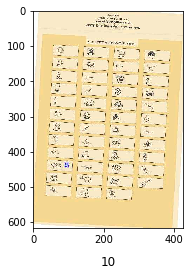

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
# sample = next(iter(data['test']))
# rand_num = np.random.randint(0, len(sample))
sample = datasets['test'][0]
img = sample['image'].squeeze(0).numpy().astype(int).transpose(1,2,0)

plt.title(sample['label'].item(), y=-0.2)
plt.imshow(img, cmap="gray")
# some preview in test image.


In [15]:
def predict(model, img):
    model = model.eval()
    img = img.to(device)
    model = model.to(device)
    with torch.no_grad():
        prediction = model(img)
        _, prediction = torch.max(prediction.data, 1)
        return prediction.item()

In [16]:
# some preview in test image.

prediction = predict(model, sample['image'].unsqueeze(0))
print("Actual Class:{}, Prediction:{}".format(sample['label'],prediction))

Actual Class:10, Prediction:10
